In [1]:
from frozen_lake import *
env = FrozenLakeEnvSequentialMultigoal(goal=2)
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S   : starting point, safe
    F   : frozen surface, safe
    H   : hole, fall to your doom
    1|2 : goal for agent 1 or agent 2

    The episode ends when you reach the all the goals for a corresponding agent.
    You receive a reward of 1 each time you reach a goal, and zero otherwise.

    


In [2]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
import scipy.sparse
import matplotlib.pyplot as plt
import math
import pickle
from collections import defaultdict
%matplotlib inline

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)

NUM_ITER = 75
GAMMA = 0.95

In [3]:
def categorical_sample(prob_n):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np.random.rand()).argmax()

class MDP(object):
    def __init__(self, env):
        P, nS, nA, desc = MDP.env2mdp(env)
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
        self.env = env
        self.T = None

    def env2mdp(env):
        return {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc
    
    def get_transition_matrix(self):
        """Return a matrix with index S,A,S' -> P(S'|S,A)"""
        if self.T is None:
            print('generating')
#             T = defaultdict(lambda : 0)
            T = np.zeros([self.nS, self.nA, self.nS])
            for s in range(self.nS):
                for a in range(self.nA):
                    transitions = self.P[s][a]
                    s_a_s = {t[1]:t[0] for t in transitions}
                    for s_prime in range(self.nS):
                        if s_prime in s_a_s:
                            T[s, a, s_prime] = s_a_s[s_prime]
            self.T = T
        return self.T
    
    def sample_transition(self, state, action):
        sas = self.P[state][action]
        sample = categorical_sample([s_prime[0] for s_prime in sas])
        return sas[sample][1]
        
    
mdp = MDP(env)

In [4]:
def compute_traj_likelihood(mdp, traj, actions):
    """
    Naive likelihood calculation. Should work ok for simple gridworld with short trajectories
    """
    transitions = [(traj[i], actions[i], traj[i+1]) for i in range(len(traj)-1)]
    likelihood = 1.0
    for s,a,s_prime in transitions:
        t = mdp.P[s][a]
        transition_prob = 0.0
        for p, nextstate, _ in t:
            if nextstate == s_prime:
                transition_prob = p
        likelihood *= transition_prob
    return likelihood

def normalize(*args):
    assert min(args) >= 0
    normalized = []
    total = sum(args)
    if total == 0:
        return args
    for arg in args:
        normalized.append(arg / total)
    return tuple(normalized)

In [5]:
class Belief:
    def __init__(self, state_index, total_states, p):
        self.state_index = state_index
        self.total_states = total_states
        self.p = p
    
    def update_p(self, new_p):
        self.p = new_p
    
    @property
    def vector(self):
        v = np.zeros(self.total_states * 2)
        v[self.state_index * 2] = self.p
        v[self.state_index *2 + 1] = 1.0 - self.p
        v = v.reshape([-1, 1])
        return v
    
    def __eq__(self, b2):
        return b2.p == self.p and b2.state_index == self.state_index
    
    def __sub__(self, b2):
        """return L1 distance between belief vectors"""
        if self.state_index == b2.state_index:
            return abs(self.p - b2.p) + abs((1-self.p) - (1-b2.p))
        else:
            return 2.0
        
def generate_belief_points(initial_belief, mdp1, mdp2, num_points=1e3, max_iters=200):
    points = np.array([initial_belief])
    mdps = [mdp1, mdp2]
    iters = 0
    while len(points) < num_points and iters < max_iters:
        frontier = np.array([])
        for b in points:
            mdp = mdps[categorical_sample([b.p, 1.0 - b.p])]
            action_points = [0]*mdp.nA
            for a in np.random.permutation(range(mdp.nA)):
               
                new_state = mdp.sample_transition(b.state_index, a)
                lik1 = compute_traj_likelihood(mdp1, [b.state_index, new_state], [a])
                lik2 = compute_traj_likelihood(mdp2, [b.state_index, new_state], [a])
                new_p = normalize(b.p*lik1, (1.0 - b.p)*lik2)[0]
                action_points[a] = Belief(new_state, b.total_states, new_p)
            
            action_points = np.array(action_points)
            distances = points.reshape([-1, 1]) - action_points.reshape([1, -1])
            min_distances = np.min(distances, axis=0)
            
            new_point = action_points[np.argmax(min_distances)]
            
            if new_point not in points:
                points = np.append(points, new_point)
                
        iters += 1
#         points = np.append(points, frontier)
    return points

In [8]:
def compute_belief_vector(mdp1, mdp2, b, a, obs):
    T1 = mdp1.get_transition_matrix()
    T2 = mdp2.get_transition_matrix()
    
    def p_s_a_sprime(sas_list, sprime):
        t = {sas[1] : sas[0] for sas in sas_list}
        try:
            return t[sprime]
        except:
            return 0.0
    
    new_b = np.zeros(mdp1.nS * 2)
    new_b[obs*2] = T1[b.state_index, a, obs]*b.p
    new_b[obs*2+1] = T2[b.state_index, a, obs]*(1 - b.p)
    Z = T1[b.state_index, a, obs]*b.p + T2[b.state_index, a, obs]*(1 - b.p)
    
    return new_b, Z

def pbvi(mdp1, mdp2, initial_belief, num_points=100, num_iter=100, gamma=1.0):
    belief_points = generate_belief_points(initial_belief, mdp1, mdp2, num_points)
    print("Number of belief points: {}".format(len(belief_points)))
    support_vectors = set()
    T1, T2 = mdp1.get_transition_matrix(), mdp2.get_transition_matrix()
    for _ in range(num_iter):
        print(_)
        
        support_vector_matrix = np.zeros([len(support_vectors), mdp1.nS*2])
        for i, v in enumerate(support_vectors):
            support_vector_matrix[i] = v[0]
        
        new_support_vectors = set()
        
        for b in belief_points:
            alpha_z_a = np.zeros([mdp1.nS, mdp1.nA, len(b.vector)])
            for obs in range(mdp1.nS):
                for a in range(mdp1.nA):
                    if len(support_vectors) == 0:
                        continue
                    new_belief_vector, Z = compute_belief_vector(mdp1, mdp2, b, a, obs)
                    if Z != 0:
#                         support_vector_matrix = np.random.permutation(support_vector_matrix)
                        values = support_vector_matrix.dot(new_belief_vector/Z)
                        alpha_z_a[obs, a, :] = support_vector_matrix[np.argmax(values)]
                    
            action_support_vectors = np.zeros([len(b.vector), mdp1.nA]) - 0.02
#             for s in range(len(b.vector)):
            for s in [b.state_index*2, b.state_index*2+1]:
                if b.vector[s] == 0:
                    continue
                ground_state = math.floor(s/2)
                for a in range(mdp1.nA):
                    if (s % 2) == 0:
                        mdp = mdp1
                        reward_sum = sum([s_prime[0]*alpha_z_a[s_prime[1], a, s_prime[1]*2] for s_prime in mdp.P[ground_state][a]])
                    else:
                        mdp = mdp2
                        reward_sum = sum([s_prime[0]*alpha_z_a[s_prime[1], a, s_prime[1]*2 + 1] for s_prime in mdp.P[ground_state][a]])
                        
                    action_support_vectors[s,a] = sum([s_prime[0]*s_prime[2] for s_prime in mdp.P[ground_state][a]]) + gamma * reward_sum
            
            values = np.dot(action_support_vectors.T, b.vector)
            max_action = np.argmax(values)
            new_support_vectors.add((tuple(action_support_vectors.T[max_action]), max_action))
#             if _ >= 2 and max_action == 8:
#                 print(action_support_vectors.T[max_action])
        
#         support_vectors = support_vectors.union(new_support_vectors)
        if support_vectors == new_support_vectors:
            break
        support_vectors = new_support_vectors.copy()
        print('len', len(support_vectors))
#         print('actions', [v[1] for v in support_vectors])
            
    return support_vectors

In [9]:
mdp1 = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))
mdp2 = MDP(FrozenLakeEnvSequentialMultigoal(goal=2, is_slippery=True))
initial_belief = Belief(24<<2, mdp1.nS, 0.5)
support_vectors = pbvi(mdp1, mdp2, initial_belief, 400, num_iter=500)

Number of belief points: 522
generating
generating
0
len 126
1
len 124
2
len 130
3
len 129
4
len 136
5
len 149
6
len 161
7
len 180
8
len 197
9
len 200
10
len 221
11
len 224
12
len 241
13
len 237
14
len 262
15
len 279
16
len 297
17
len 307
18
len 308
19
len 305
20
len 304
21
len 304
22
len 297
23
len 296
24
len 299
25
len 295
26
len 298
27
len 301
28
len 295
29
len 295
30
len 296
31
len 297
32
len 297
33
len 297
34
len 299
35
len 302
36
len 303
37
len 303
38
len 303
39
len 303
40
len 303
41
len 303
42
len 303
43
len 303
44
len 303
45
len 303
46
len 303
47
len 303
48
len 303
49
len 303
50
len 303
51
len 303
52
len 303
53
len 303
54
len 303
55
len 303
56
len 303
57
len 303
58
len 303
59
len 303
60
len 303
61
len 303
62
len 303
63
len 303
64
len 303
65
len 303
66
len 303
67
len 303
68
len 303
69
len 303
70
len 303
71
len 303
72
len 303
73
len 303
74
len 303
75
len 303
76
len 303
77
len 303
78
len 303
79
len 303
80
len 303
81
len 303
82
len 303
83
len 303
84
len 303
85
len 303
86
len 303
87

In [10]:
pickle.dump(support_vectors, open('support_vectors.pkl', 'wb'))

In [11]:
support_vectors = pickle.load(open('support_vectors.pkl', 'rb'))

In [14]:
def plot_values(V, pi, s):
    V = V[:-1]
    goals = s % 4
    goal_inds = [i for i in range(len(V)) if i % 4 == goals]
    V = V[goal_inds]
    V -= np.min(V)
    V /= max(V) if max(V) > 0 else 1.0
#     print(V)
    pi = pi[goal_inds]
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(8,8), cmap='gray', interpolation='none', aspect='auto', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(8)-.5)
    ax.set_yticks(np.arange(8)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:8, 0:8]
    a2uv = {0:(-1, 0), 2:(0, -1), 4:(1, 0), 6:(0, 1),
            1:(-1, -1), 3:(1, -1), 5:(1, 1), 7:(-1, 1),
            8:(0, 0)}
    Pi = pi.reshape(8,8)
    for y in range(8):
        for x in range(8):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1)
            if str(env.desc[y,x].item().decode()) in '12':
                plt.text(x, y, str(env.desc[y,x].item().decode()),
                         color='g', size=12,  verticalalignment='center',
                         horizontalalignment='center', fontweight='bold')
    
    if s != (8 * 8 * 4):
        plt.plot((s >> 2)%8, (s >> 2)//8, 'ro')
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

def support_vectors_to_values(support_vectors, belief, nS, current_s):
    support_vectors = list(support_vectors)
    V = np.zeros(nS)
    pi = np.zeros(nS)
    for s in range(nS):
        b = Belief(s, belief.total_states, belief.p)
        vectors = [v[0] for v in support_vectors]
        values = [np.array(alpha).dot(b.vector) for alpha in vectors]
#         if s == (24 << 2) + 3:
#             print(values)
        V[s] = max(values)
        pi[s] = support_vectors[np.argmax(values)][1]
#     active_indices = list(filter(lambda x: x % 16 == current_s % 16, range(nS)))
#     V = V[active_indices]
#     pi = pi[active_indices]
    return V, pi
    
    
def run_mixing_agent(true_mdp, mdp1, mdp2, support_vectors, w1, vis=plot_values):
    true_mdp.env.reset()
    s1 = mdp1.env.reset()
    s2 = mdp2.env.reset()
    assert s1 == s2, "mdp state spaces must be the same"
    s, done = s1, False
    
    Vs = []
    pi = np.zeros(mdp1.nS)
    
#     w1, w2 = normalize(p1, p2)
    traj, actions = [s,], []
#     V1, V2 = compute_values(mdp1, mdp2, GAMMA, NUM_ITER)
    belief = Belief(s, true_mdp.nS, w1)

    while not done:
        print("acting")
        V, pi = support_vectors_to_values(support_vectors, belief, true_mdp.nS, s)
        if vis:
            vis(V, pi, s)
            print(belief.p)
        action = pi[s]
        s, r, done, _ = true_mdp.env.step(action)
        traj.append(s)
        actions.append(action)
        l1, l2 = compute_traj_likelihood(mdp1, traj, actions), compute_traj_likelihood(mdp2, traj, actions)
        p1, p2 = normalize(w1*l1, (1-w1)*l2)
        belief = Belief(s, true_mdp.nS, p1)
    if vis:
        vis(V, pi, s)
    return traj


acting


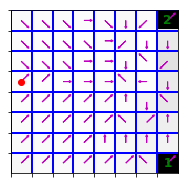

0.5
acting


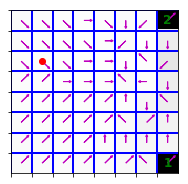

0.5555555555555556
acting


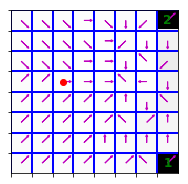

0.6097560975609756
acting


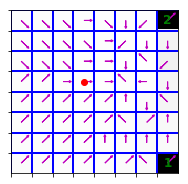

0.6613756613756614
acting


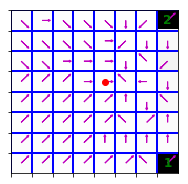

0.7094211123723041
acting


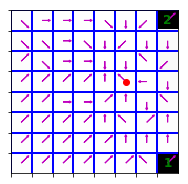

0.7531935406121956
acting


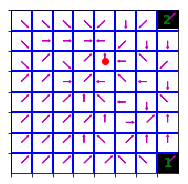

0.7923026215709141
acting


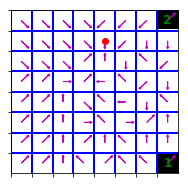

0.8266408490196699
acting


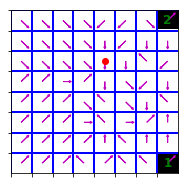

0.8563314268427155
acting


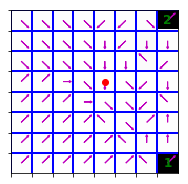

0.8816649354999324
acting


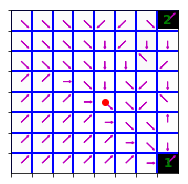

0.9030371268298045
acting


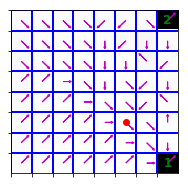

0.9208956647384071
acting


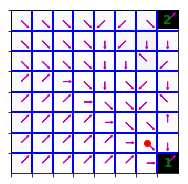

0.9356992379835
acting


In [ ]:
mdp1 = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))
mdp2 = MDP(FrozenLakeEnvSequentialMultigoal(goal=2, is_slippery=True))
true_mdp = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))

traj = run_mixing_agent(true_mdp, mdp1, mdp2, support_vectors, w1=0.5)

In [ ]:
V, pi = support_vectors_to_values(support_vectors, Belief(64 << 2 + 3, mdp1.nS, 0.5), mdp1.nS, None)

In [ ]:
V

In [ ]:
pi

In [ ]:
0.85590749

In [ ]:
[v[0] for v in support_vectors if v[1] == 8][0]